### eval testing

## import lib & var setting

In [1]:
# Import Pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visulization
import matplotlib.pyplot as plt

import sys 

import cv2

import pandas as pd  # 資料分析套件
import numpy as np
import os
from time import time
import re
from timeit import default_timer as timer

# enable discord notifier
import asyncio, nest_asyncio
from python_tools.discord_bot import async_discord_bot_notifier, discord_bot_notifier
nest_asyncio.apply()

In [2]:
# ===== var setting   ========

# csv_file = '../data/img_feature.csv'
# csv_file = '../data/img_feature_no_masked.csv'
csv_file = '../data/img_conv2.csv'
# random_seed = 42
# dataset_path = "../HAM10000/base_img_data/"
dataset_path = "../HAM10000/images/"
groundtruth_file = '../HAM10000/GroundTruth.csv'

## prepocessing train & test data

### create name to label dict

### 分出train 跟test的data loader

In [3]:
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from helperFunction.CustomImageDataset import CustomImageDataset 


gray_mean = sum([0.485, 0.456, 0.406]) / 3
gray_std = sum([0.229, 0.224, 0.225]) / 3


# 可以加入轉換
transform64 = torchvision.transforms.Compose([
    transforms.Resize(size=(64,64)),
    torchvision.transforms.ToTensor()
    # 其他轉換
])

transform_std = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_gray_single_channel = transforms.Compose([
    transforms.Resize(256),  # 调整图像大小至256x256
    transforms.CenterCrop(224),  # 中心裁剪至224x224
    transforms.Grayscale(),  # 将图像转换为灰度图
    transforms.ToTensor(),  # 转换为Tensor
    # 归一化，均值和标准差应根据灰度图的实际分布进行调整
    # 这里使用ImageNet预训练模型的均值和标准差的平均值作为示例
    transforms.Normalize(mean=[0.449], std=[0.226]),
])

transform_gray_pretrain_fit = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # 将图像转换为单通道灰度图像
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 复制灰度通道到三个通道
    # 其他需要的转换，如 Resize, Normalize 等
    transforms.Resize(256),  # 例如，调整图像大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 归一化
])

transform_gray_CT_img_fit = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # 将图像转换为单通道灰度图像
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 复制灰度通道到三个通道
    # 其他需要的转换，如 Resize, Normalize 等
    transforms.Resize(256),  # 例如，调整图像大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[gray_mean,gray_mean,gray_mean], std=[gray_std,gray_std,gray_std]),  # 归一化
])




In [4]:
# @transform test unit

# image = Image.open('../data/chestCTData/images/train/adenocarcinoma/000000 (6).png')

# # 打印图像的格式
# print("Format:", image.format)

# # 打印图像的尺寸
# print("Size:", image.size)

# # 打印图像的模式
# print("Mode:", image.mode)

# # 打印图像的额外信息（如果有的话）
# print("Info:", image.info)

# # 将图像转换为NumPy数组
# image_array = np.array(image)

# # 打印图像数组的形状和部分像素值
# print("Image shape:", image_array.shape)
# print("Some pixel values:", image_array[100:110, 100:110])  # 打印左上角5x5区域的像素值

# transformed_img = transform_gray(image)

# print(transformed_img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


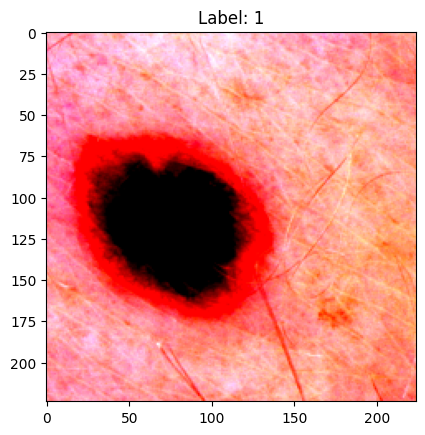

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


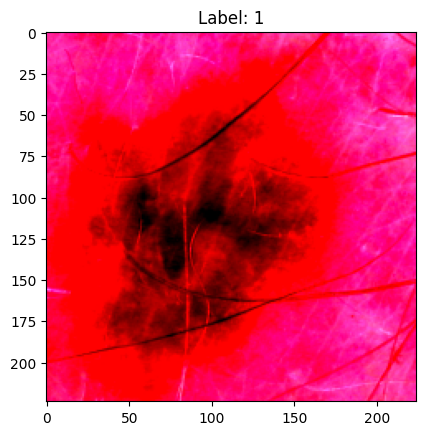

In [5]:
sys.path.append(os.path.abspath('..'))

from data.chestCTData.chestCTDataloader import ChestCTDataProcessor
from data.HAM10000.ham10000Dataloader import HAM10000DataProcessor
from data.ocularDisease.ocularDataloader import OcularDiseaseDataProcessor

# dataContainer = ChestCTDataProcessor(transform=transform_gray_single_channel) # for [1,224,224]
# dataContainer = ChestCTDataProcessor(transform=transform_std) # for [3,224,224]
dataContainer = HAM10000DataProcessor(transform=transform_std)
# dataContainer = OcularDiseaseDataProcessor(transform=transform_std)


# model_folder_path = '../model/CT chest'
model_folder_path = '../model/HAM10000'
# model_folder_path = '../model/ocularDisease'

# transform_file_prefix = "/one_channel"
transform_file_prefix = "/three_channel"

train_dataloader , test_dataloader = dataContainer.getDataloaders()

num_classes = dataContainer.getNumClasses()

# dataContainer.dataPreprocess()

dataContainer.plotNumsSampleImg()

In [6]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can cahnge the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}") # equal to batch siz

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [7]:
# 儲存file list的資訊給XGB訓練時使用
# import json
# with open('test_files_list.json', 'w') as f:
#     json.dump(test_files, f)
# with open('train_files_list.json', 'w') as f:
#     json.dump(train_files, f)

In [8]:
import torch
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Train & test function defination

In [9]:
# Cteate train_step()
def train_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop thourgh data loader data batches
  for batch,(X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device) , y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5 Optimizer step
    optimizer.step()

    # Calculat accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [10]:
from sklearn.metrics import f1_score
# Create a test step
def test_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device=device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc, all_preds, all_labels = 0, 0, [], []

  with torch.inference_mode():
    # Loop thourgh data loader data batches
    for batch,(X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device) , y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()


      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1) # Maybe same as softmax results?
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

      all_preds.extend(test_pred_labels.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  # cal F1 score
  f1 = f1_score(all_labels, all_preds, average='weighted')

  return test_loss, test_acc, f1

In [11]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss functoin
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          best_model_name: str = "best_model.pth",
          device=device,
          enable_early_stop=True):
  # 2. Create empty results dicitonary
  results = {"train_loss": [],
        "train_acc":[],
        "test_loss": [],
        "test_acc":[]}
  
  # init best model loss var
  best_test_loss = float('inf')
  best_model = None
  early_stop_count = 0
  early_stop_limit = 7

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                        dataloader=train_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device)
    test_loss, test_acc, test_f1 = test_step(model=model,
                      dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      device=device)
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} |  F1 score: {test_f1:.4f}   ")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      best_test_acc = test_acc
      best_test_f1 = test_f1
      # best_model = model.state_dict()
      torch.save(model.state_dict(), best_model_name)
      early_stop_count = 0
    else:
      if enable_early_stop:
        early_stop_count += 1
    
    if early_stop_count >= early_stop_limit:
      print("Early stopping triggered.")
      break

  # 6. Return the filled results at the end of the eopchs
      
  # save best model
  # torch.save(best_model, best_model_name)
  print("the best test acc is :{:.4f}".format(best_test_acc))
  print("the best F1 score is :{:.4f}".format(best_test_f1))
  return results

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train model

## VGG

output == 7 pretrain VGG

In [12]:
import torchvision.models as models

model_preTrained_VGG16 = models.vgg16(pretrained=True)    # 使用內建的 model 


optimizer = torch.optim.SGD(model_preTrained_VGG16.parameters(), lr = 0.001) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

#=========
import torch
import torch.nn as nn
import torchvision.models as models




# 获取分类器中最后一个全连接层之前的部分
classifier = list(model_preTrained_VGG16.classifier.children())[:-1]

# 移除原始模型的最后一个全连接层
# 并添加一个新的全连接层，输出特征数为 "先前設定的class數"
classifier.append(torch.nn.Linear(4096, num_classes))

# 替换原始模型的分类器
model_preTrained_VGG16.classifier = torch.nn.Sequential(*classifier)

# ============


model_preTrained_VGG16 =  model_preTrained_VGG16.to(device)

from torchinfo import summary

summary(model_preTrained_VGG16, input_size=[1,3,224,224])



# Start the timer


# from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG16_results = train(model=model_preTrained_VGG16,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_VGG16.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.6522 | Train acc: 0.3881 | Test loss: 1.4180 | Test acc: 0.4750 |  F1 score: 0.3507   


  2%|▎         | 1/40 [05:23<3:30:23, 323.68s/it]

Epoch: 1 | Train loss: 1.5001 | Train acc: 0.4357 | Test loss: 1.3423 | Test acc: 0.4891 |  F1 score: 0.3484   


  5%|▌         | 2/40 [10:29<3:18:24, 313.27s/it]

Epoch: 2 | Train loss: 1.4268 | Train acc: 0.4775 | Test loss: 1.2934 | Test acc: 0.5430 |  F1 score: 0.4623   


  8%|▊         | 3/40 [15:26<3:08:29, 305.67s/it]

Epoch: 3 | Train loss: 1.3750 | Train acc: 0.5003 | Test loss: 1.2532 | Test acc: 0.5641 |  F1 score: 0.4844   


 10%|█         | 4/40 [20:23<3:01:21, 302.28s/it]

Epoch: 4 | Train loss: 1.3287 | Train acc: 0.5203 | Test loss: 1.2020 | Test acc: 0.5742 |  F1 score: 0.4888   


 12%|█▎        | 5/40 [25:20<2:55:10, 300.30s/it]

Epoch: 5 | Train loss: 1.2947 | Train acc: 0.5368 | Test loss: 1.1960 | Test acc: 0.5656 |  F1 score: 0.5021   


 15%|█▌        | 6/40 [30:18<2:49:45, 299.57s/it]

Epoch: 6 | Train loss: 1.2496 | Train acc: 0.5457 | Test loss: 1.1787 | Test acc: 0.5539 |  F1 score: 0.4953   


 18%|█▊        | 7/40 [35:11<2:43:39, 297.57s/it]

Epoch: 7 | Train loss: 1.2240 | Train acc: 0.5581 | Test loss: 1.1303 | Test acc: 0.5867 |  F1 score: 0.5123   


 20%|██        | 8/40 [40:05<2:38:06, 296.46s/it]

Epoch: 8 | Train loss: 1.1903 | Train acc: 0.5701 | Test loss: 1.1215 | Test acc: 0.5852 |  F1 score: 0.5184   


 25%|██▌       | 10/40 [49:52<2:27:22, 294.74s/it]

Epoch: 9 | Train loss: 1.1762 | Train acc: 0.5727 | Test loss: 1.1237 | Test acc: 0.5789 |  F1 score: 0.5227   
Epoch: 10 | Train loss: 1.1494 | Train acc: 0.5790 | Test loss: 1.0918 | Test acc: 0.5984 |  F1 score: 0.5358   


 30%|███       | 12/40 [59:40<2:17:23, 294.41s/it]

Epoch: 11 | Train loss: 1.1282 | Train acc: 0.5892 | Test loss: 1.1091 | Test acc: 0.5828 |  F1 score: 0.5378   
Epoch: 12 | Train loss: 1.1077 | Train acc: 0.5895 | Test loss: 1.0566 | Test acc: 0.6062 |  F1 score: 0.5463   


 32%|███▎      | 13/40 [1:04:35<2:12:33, 294.58s/it]

Epoch: 13 | Train loss: 1.0882 | Train acc: 0.6005 | Test loss: 1.0521 | Test acc: 0.6203 |  F1 score: 0.5605   


 35%|███▌      | 14/40 [1:09:30<2:07:46, 294.85s/it]

Epoch: 14 | Train loss: 1.0665 | Train acc: 0.6073 | Test loss: 1.0367 | Test acc: 0.6195 |  F1 score: 0.5656   


 40%|████      | 16/40 [1:19:20<1:57:51, 294.65s/it]

Epoch: 15 | Train loss: 1.0552 | Train acc: 0.6149 | Test loss: 1.0741 | Test acc: 0.5836 |  F1 score: 0.5585   


 42%|████▎     | 17/40 [1:24:13<1:52:50, 294.38s/it]

Epoch: 16 | Train loss: 1.0214 | Train acc: 0.6278 | Test loss: 1.0424 | Test acc: 0.6211 |  F1 score: 0.5617   


 45%|████▌     | 18/40 [1:29:07<1:47:54, 294.27s/it]

Epoch: 17 | Train loss: 1.0141 | Train acc: 0.6287 | Test loss: 1.1101 | Test acc: 0.5523 |  F1 score: 0.5338   


 48%|████▊     | 19/40 [1:34:01<1:42:54, 294.01s/it]

Epoch: 18 | Train loss: 0.9929 | Train acc: 0.6309 | Test loss: 1.0522 | Test acc: 0.5945 |  F1 score: 0.5760   
Epoch: 19 | Train loss: 0.9570 | Train acc: 0.6477 | Test loss: 1.0131 | Test acc: 0.6164 |  F1 score: 0.5929   


 50%|█████     | 20/40 [1:38:56<1:38:07, 294.35s/it]

Epoch: 20 | Train loss: 0.9491 | Train acc: 0.6470 | Test loss: 0.9878 | Test acc: 0.6297 |  F1 score: 0.5845   


 55%|█████▌    | 22/40 [1:48:45<1:28:17, 294.30s/it]

Epoch: 21 | Train loss: 0.9261 | Train acc: 0.6597 | Test loss: 1.0608 | Test acc: 0.5813 |  F1 score: 0.5654   
Epoch: 22 | Train loss: 0.9097 | Train acc: 0.6700 | Test loss: 0.9782 | Test acc: 0.6359 |  F1 score: 0.6081   


 57%|█████▊    | 23/40 [1:53:41<1:23:31, 294.79s/it]

Epoch: 23 | Train loss: 0.8833 | Train acc: 0.6706 | Test loss: 0.9683 | Test acc: 0.6359 |  F1 score: 0.6029   


 60%|██████    | 24/40 [1:58:36<1:18:41, 295.09s/it]

Epoch: 24 | Train loss: 0.8718 | Train acc: 0.6817 | Test loss: 0.9620 | Test acc: 0.6414 |  F1 score: 0.6058   


 65%|██████▌   | 26/40 [2:08:25<1:08:44, 294.58s/it]

Epoch: 25 | Train loss: 0.8421 | Train acc: 0.6876 | Test loss: 0.9794 | Test acc: 0.6391 |  F1 score: 0.6186   


 68%|██████▊   | 27/40 [2:13:16<1:03:37, 293.62s/it]

Epoch: 26 | Train loss: 0.8293 | Train acc: 0.6968 | Test loss: 0.9851 | Test acc: 0.6469 |  F1 score: 0.6039   
Epoch: 27 | Train loss: 0.7974 | Train acc: 0.7048 | Test loss: 0.9550 | Test acc: 0.6492 |  F1 score: 0.6260   


 72%|███████▎  | 29/40 [2:23:06<53:54, 294.04s/it]  

Epoch: 28 | Train loss: 0.7877 | Train acc: 0.7146 | Test loss: 0.9724 | Test acc: 0.6422 |  F1 score: 0.6072   


 75%|███████▌  | 30/40 [2:28:00<49:01, 294.19s/it]

Epoch: 29 | Train loss: 0.7771 | Train acc: 0.7162 | Test loss: 0.9592 | Test acc: 0.6516 |  F1 score: 0.6259   
Epoch: 30 | Train loss: 0.7477 | Train acc: 0.7230 | Test loss: 0.9480 | Test acc: 0.6492 |  F1 score: 0.6291   


 80%|████████  | 32/40 [2:37:50<39:16, 294.56s/it]

Epoch: 31 | Train loss: 0.7304 | Train acc: 0.7328 | Test loss: 0.9565 | Test acc: 0.6578 |  F1 score: 0.6338   


 82%|████████▎ | 33/40 [2:42:45<34:22, 294.71s/it]

Epoch: 32 | Train loss: 0.7082 | Train acc: 0.7427 | Test loss: 1.0437 | Test acc: 0.6164 |  F1 score: 0.5912   


 85%|████████▌ | 34/40 [2:47:40<29:28, 294.67s/it]

Epoch: 33 | Train loss: 0.6922 | Train acc: 0.7490 | Test loss: 1.0492 | Test acc: 0.6406 |  F1 score: 0.6055   


 88%|████████▊ | 35/40 [2:52:35<24:33, 294.74s/it]

Epoch: 34 | Train loss: 0.6620 | Train acc: 0.7593 | Test loss: 1.1141 | Test acc: 0.6391 |  F1 score: 0.5912   


 90%|█████████ | 36/40 [2:57:30<19:39, 294.88s/it]

Epoch: 35 | Train loss: 0.6549 | Train acc: 0.7616 | Test loss: 1.0555 | Test acc: 0.6195 |  F1 score: 0.6020   


 92%|█████████▎| 37/40 [3:02:25<14:44, 294.88s/it]

Epoch: 36 | Train loss: 0.6185 | Train acc: 0.7767 | Test loss: 1.0429 | Test acc: 0.6430 |  F1 score: 0.6215   


 92%|█████████▎| 37/40 [3:07:20<15:11, 303.79s/it]

Epoch: 37 | Train loss: 0.5961 | Train acc: 0.7828 | Test loss: 1.1525 | Test acc: 0.6289 |  F1 score: 0.5901   
Early stopping triggered.
the best test acc is :0.6492
the best F1 score is :0.6291
Total training time: 11240.070 seconds


## Resnet 18

output == 7 pretrain resnet

In [13]:
import torchvision.models as models

model_preTrained_Resnet18 = models.resnet18(pretrained=True)     # 使用內建的 model 


# optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001) # 選擇你想用的 optimizer
optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001, momentum=0.9) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet18.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

# ========================

# change fully connected layer to 7
num_ftrs = model_preTrained_Resnet18.fc.in_features
model_preTrained_Resnet18.fc = nn.Linear(num_ftrs, num_classes)

# device setting
model_preTrained_Resnet18 = model_preTrained_Resnet18.to(device)

# ===========================

# summary(model_preTrained_Resnet18)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet18.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

asyncio.run(
    async_discord_bot_notifier("resnet訓練完成!")
)

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▎         | 1/40 [04:25<2:52:45, 265.79s/it]

Epoch: 0 | Train loss: 1.8080 | Train acc: 0.3651 | Test loss: 1.5418 | Test acc: 0.5352 |  F1 score: 0.4929   


  5%|▌         | 2/40 [08:51<2:48:25, 265.93s/it]

Epoch: 1 | Train loss: 1.3079 | Train acc: 0.5789 | Test loss: 1.2359 | Test acc: 0.6000 |  F1 score: 0.5397   


  8%|▊         | 3/40 [13:18<2:44:07, 266.16s/it]

Epoch: 2 | Train loss: 1.1257 | Train acc: 0.6257 | Test loss: 1.1931 | Test acc: 0.6141 |  F1 score: 0.5628   


 10%|█         | 4/40 [17:43<2:39:31, 265.88s/it]

Epoch: 3 | Train loss: 0.9906 | Train acc: 0.6664 | Test loss: 1.1567 | Test acc: 0.6227 |  F1 score: 0.5805   


 12%|█▎        | 5/40 [22:10<2:35:17, 266.22s/it]

Epoch: 4 | Train loss: 0.8517 | Train acc: 0.7222 | Test loss: 1.1832 | Test acc: 0.6164 |  F1 score: 0.5710   


 15%|█▌        | 6/40 [26:36<2:30:50, 266.20s/it]

Epoch: 5 | Train loss: 0.7311 | Train acc: 0.7646 | Test loss: 1.1654 | Test acc: 0.6281 |  F1 score: 0.6020   


 18%|█▊        | 7/40 [31:02<2:26:21, 266.11s/it]

Epoch: 6 | Train loss: 0.5792 | Train acc: 0.8289 | Test loss: 1.3585 | Test acc: 0.6141 |  F1 score: 0.5757   


 20%|██        | 8/40 [35:29<2:21:58, 266.20s/it]

Epoch: 7 | Train loss: 0.4461 | Train acc: 0.8769 | Test loss: 1.3341 | Test acc: 0.6117 |  F1 score: 0.5878   


 22%|██▎       | 9/40 [39:56<2:17:41, 266.50s/it]

Epoch: 8 | Train loss: 0.3180 | Train acc: 0.9267 | Test loss: 1.3197 | Test acc: 0.6023 |  F1 score: 0.5868   


 25%|██▌       | 10/40 [44:22<2:13:09, 266.32s/it]

Epoch: 9 | Train loss: 0.2210 | Train acc: 0.9544 | Test loss: 1.4058 | Test acc: 0.5969 |  F1 score: 0.5871   


 25%|██▌       | 10/40 [48:49<2:26:28, 292.95s/it]
[2024-03-29 20:13:14] [INFO    ] discord.client: logging in using static token


Epoch: 10 | Train loss: 0.1553 | Train acc: 0.9771 | Test loss: 1.5063 | Test acc: 0.5938 |  F1 score: 0.5823   
Early stopping triggered.
the best test acc is :0.6227
the best F1 score is :0.5805
Total training time: 2929.527 seconds


[2024-03-29 20:13:15] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 1b510d60cb7c7385ff9ace118cb68877).


已登录为 python bot#2920


## Densenet

In [12]:
import torch
import torchvision.models as models
from torchinfo import summary

# 加载预训练的 DenseNet121
model_preTrained_densenet121 = models.densenet121(pretrained=True)

# Optimizer
optimizer = torch.optim.SGD(model_preTrained_densenet121.parameters(), lr = 0.001) # 選擇你想用的 optimizer
# optimizer = torch.optim.Adam(model_densenet121.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                

# 更換classifier的輸出
model_preTrained_densenet121.classifier = nn.Linear(model_preTrained_densenet121.classifier.in_features, num_classes)

print(model_preTrained_densenet121.classifier)

model_preTrained_densenet121 =  model_preTrained_densenet121.to(device)


summary(model_preTrained_densenet121, input_size=[1,3,224,224])



# Start the timer


# from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_densenet121_results = train(model=model_preTrained_densenet121,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_densenet121.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


asyncio.run(
    async_discord_bot_notifier("densenet訓練完成!")
)

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=1024, out_features=7, bias=True)


  2%|▎         | 1/40 [02:28<1:36:31, 148.50s/it]

Epoch: 0 | Train loss: 2.0245 | Train acc: 0.1216 | Test loss: 1.8356 | Test acc: 0.3301 |  F1 score: 0.4213   


  5%|▌         | 2/40 [04:46<1:30:10, 142.37s/it]

Epoch: 1 | Train loss: 1.6847 | Train acc: 0.4260 | Test loss: 1.5529 | Test acc: 0.5363 |  F1 score: 0.5998   


  8%|▊         | 3/40 [07:01<1:25:50, 139.20s/it]

Epoch: 2 | Train loss: 1.3514 | Train acc: 0.6197 | Test loss: 1.1863 | Test acc: 0.6838 |  F1 score: 0.6885   


 10%|█         | 4/40 [09:17<1:22:37, 137.71s/it]

Epoch: 3 | Train loss: 1.0997 | Train acc: 0.7170 | Test loss: 1.0114 | Test acc: 0.7371 |  F1 score: 0.7131   


 12%|█▎        | 5/40 [11:31<1:19:40, 136.58s/it]

Epoch: 4 | Train loss: 0.9793 | Train acc: 0.7544 | Test loss: 0.9213 | Test acc: 0.7559 |  F1 score: 0.7295   


 15%|█▌        | 6/40 [13:46<1:17:01, 135.94s/it]

Epoch: 5 | Train loss: 0.8949 | Train acc: 0.7687 | Test loss: 0.8614 | Test acc: 0.7541 |  F1 score: 0.7173   


 18%|█▊        | 7/40 [16:01<1:14:38, 135.70s/it]

Epoch: 6 | Train loss: 0.8406 | Train acc: 0.7743 | Test loss: 1.1450 | Test acc: 0.7377 |  F1 score: 0.7324   


 20%|██        | 8/40 [18:16<1:12:15, 135.48s/it]

Epoch: 7 | Train loss: 0.7947 | Train acc: 0.7859 | Test loss: 0.8080 | Test acc: 0.7690 |  F1 score: 0.7360   


 22%|██▎       | 9/40 [20:32<1:09:56, 135.36s/it]

Epoch: 8 | Train loss: 0.7575 | Train acc: 0.7934 | Test loss: 0.7603 | Test acc: 0.7814 |  F1 score: 0.7542   


 25%|██▌       | 10/40 [22:47<1:07:38, 135.28s/it]

Epoch: 9 | Train loss: 0.7070 | Train acc: 0.8057 | Test loss: 0.8325 | Test acc: 0.7461 |  F1 score: 0.6942   


 28%|██▊       | 11/40 [25:01<1:05:19, 135.14s/it]

Epoch: 10 | Train loss: 0.6852 | Train acc: 0.8088 | Test loss: 0.7460 | Test acc: 0.7729 |  F1 score: 0.7373   
Epoch: 11 | Train loss: 0.6443 | Train acc: 0.8217 | Test loss: 0.7293 | Test acc: 0.7903 |  F1 score: 0.7664   


 32%|███▎      | 13/40 [29:31<1:00:43, 134.96s/it]

Epoch: 12 | Train loss: 0.6282 | Train acc: 0.8269 | Test loss: 0.7097 | Test acc: 0.7992 |  F1 score: 0.7827   


 35%|███▌      | 14/40 [31:46<58:25, 134.84s/it]  

Epoch: 13 | Train loss: 0.6040 | Train acc: 0.8320 | Test loss: 1.0647 | Test acc: 0.7511 |  F1 score: 0.7512   


 38%|███▊      | 15/40 [34:00<56:08, 134.74s/it]

Epoch: 14 | Train loss: 0.5664 | Train acc: 0.8430 | Test loss: 0.7492 | Test acc: 0.7873 |  F1 score: 0.7807   


 40%|████      | 16/40 [36:13<53:41, 134.21s/it]

Epoch: 15 | Train loss: 0.5508 | Train acc: 0.8520 | Test loss: 0.6724 | Test acc: 0.7982 |  F1 score: 0.7760   


 42%|████▎     | 17/40 [38:26<51:18, 133.84s/it]

Epoch: 16 | Train loss: 0.5152 | Train acc: 0.8577 | Test loss: 0.6327 | Test acc: 0.8146 |  F1 score: 0.7968   


 45%|████▌     | 18/40 [40:38<48:54, 133.37s/it]

Epoch: 17 | Train loss: 0.4812 | Train acc: 0.8729 | Test loss: 0.9846 | Test acc: 0.7741 |  F1 score: 0.7820   


 48%|████▊     | 19/40 [42:51<46:34, 133.08s/it]

Epoch: 18 | Train loss: 0.4650 | Train acc: 0.8752 | Test loss: 0.6157 | Test acc: 0.8227 |  F1 score: 0.8058   


 50%|█████     | 20/40 [45:03<44:16, 132.85s/it]

Epoch: 19 | Train loss: 0.4430 | Train acc: 0.8845 | Test loss: 0.6592 | Test acc: 0.8222 |  F1 score: 0.8177   


 52%|█████▎    | 21/40 [47:16<42:02, 132.75s/it]

Epoch: 20 | Train loss: 0.4252 | Train acc: 0.8894 | Test loss: 0.6114 | Test acc: 0.8245 |  F1 score: 0.8193   


 55%|█████▌    | 22/40 [49:28<39:46, 132.56s/it]

Epoch: 21 | Train loss: 0.3989 | Train acc: 0.8982 | Test loss: 0.6108 | Test acc: 0.8219 |  F1 score: 0.8130   


 57%|█████▊    | 23/40 [51:40<37:30, 132.37s/it]

Epoch: 22 | Train loss: 0.3842 | Train acc: 0.9009 | Test loss: 0.6206 | Test acc: 0.8197 |  F1 score: 0.8025   


 60%|██████    | 24/40 [53:52<35:19, 132.47s/it]

Epoch: 23 | Train loss: 0.3594 | Train acc: 0.9110 | Test loss: 0.6069 | Test acc: 0.8245 |  F1 score: 0.8089   


 62%|██████▎   | 25/40 [56:05<33:06, 132.45s/it]

Epoch: 24 | Train loss: 0.3429 | Train acc: 0.9175 | Test loss: 0.5774 | Test acc: 0.8409 |  F1 score: 0.8337   


 65%|██████▌   | 26/40 [58:17<30:51, 132.27s/it]

Epoch: 25 | Train loss: 0.3341 | Train acc: 0.9204 | Test loss: 0.6564 | Test acc: 0.8245 |  F1 score: 0.8151   


 68%|██████▊   | 27/40 [1:00:29<28:38, 132.22s/it]

Epoch: 26 | Train loss: 0.3137 | Train acc: 0.9260 | Test loss: 0.6328 | Test acc: 0.8229 |  F1 score: 0.8216   


 70%|███████   | 28/40 [1:02:41<26:27, 132.31s/it]

Epoch: 27 | Train loss: 0.2996 | Train acc: 0.9281 | Test loss: 0.5928 | Test acc: 0.8384 |  F1 score: 0.8308   


 72%|███████▎  | 29/40 [1:04:53<24:14, 132.27s/it]

Epoch: 28 | Train loss: 0.2772 | Train acc: 0.9355 | Test loss: 0.5842 | Test acc: 0.8330 |  F1 score: 0.8213   


 75%|███████▌  | 30/40 [1:07:06<22:02, 132.25s/it]

Epoch: 29 | Train loss: 0.2570 | Train acc: 0.9433 | Test loss: 0.5824 | Test acc: 0.8419 |  F1 score: 0.8365   


 78%|███████▊  | 31/40 [1:09:18<19:50, 132.28s/it]

Epoch: 30 | Train loss: 0.2547 | Train acc: 0.9436 | Test loss: 0.6088 | Test acc: 0.8343 |  F1 score: 0.8299   


 80%|████████  | 32/40 [1:11:31<17:39, 132.49s/it]

Epoch: 31 | Train loss: 0.2447 | Train acc: 0.9460 | Test loss: 0.5581 | Test acc: 0.8462 |  F1 score: 0.8387   


 82%|████████▎ | 33/40 [1:13:44<15:28, 132.66s/it]

Epoch: 32 | Train loss: 0.2180 | Train acc: 0.9564 | Test loss: 0.6095 | Test acc: 0.8378 |  F1 score: 0.8350   


 85%|████████▌ | 34/40 [1:15:57<13:16, 132.72s/it]

Epoch: 33 | Train loss: 0.2153 | Train acc: 0.9572 | Test loss: 0.5724 | Test acc: 0.8399 |  F1 score: 0.8313   


 88%|████████▊ | 35/40 [1:18:10<11:04, 132.82s/it]

Epoch: 34 | Train loss: 0.2101 | Train acc: 0.9575 | Test loss: 0.6463 | Test acc: 0.8202 |  F1 score: 0.8053   


 90%|█████████ | 36/40 [1:20:23<08:51, 132.87s/it]

Epoch: 35 | Train loss: 0.1863 | Train acc: 0.9653 | Test loss: 0.6275 | Test acc: 0.8240 |  F1 score: 0.8075   


 92%|█████████▎| 37/40 [1:22:36<06:38, 132.91s/it]

Epoch: 36 | Train loss: 0.1826 | Train acc: 0.9655 | Test loss: 0.6470 | Test acc: 0.8194 |  F1 score: 0.8044   


 95%|█████████▌| 38/40 [1:24:49<04:25, 132.87s/it]

Epoch: 37 | Train loss: 0.1733 | Train acc: 0.9697 | Test loss: 0.7673 | Test acc: 0.7923 |  F1 score: 0.7967   


 95%|█████████▌| 38/40 [1:27:01<04:34, 137.40s/it]
[2024-04-16 03:48:02] [INFO    ] discord.client: logging in using static token


Epoch: 38 | Train loss: 0.1666 | Train acc: 0.9731 | Test loss: 0.5706 | Test acc: 0.8498 |  F1 score: 0.8436   
Early stopping triggered.
the best test acc is :0.8462
the best F1 score is :0.8387
Total training time: 5221.280 seconds


[2024-04-16 03:48:04] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 531b5b06a60a79299921791c9d284b74).


已登录为 python bot#2920


# Unused cells

### pretrain resnet num_classes = 1000

In [ ]:
import torchvision.models as models

model_preTrained_Resnet18 = models.resnet18(pretrained=True).to(device)     # 使用內建的 model 

summary(model_preTrained_Resnet18, input_size=[1,3,224,224])

optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet18.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 




# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name="best_model_pretrain_Resnet18.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

### resnet 18 :single channel model

In [ ]:
import torch
import torchvision.models as models
from torch import nn, optim

# 加载预训练的ResNet18模型
model_resnet18 = models.resnet18(pretrained=True)

# 修改第一层卷积以接受单通道输入
# ResNet18的第一层卷积的输入通道数默认为3，我们需要将其更改为1
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 如果需要，冻结模型的前几层参数
for param in model_resnet18.parameters():
    param.requires_grad = False
# 例如，解冻最后的卷积层
for param in model_resnet18.layer4.parameters():
    param.requires_grad = True

# 修改分类器以适应新的数据集
# ResNet18使用全连接层作为其分类器，我们需要根据目标数据集的类别数来调整它
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 10)  # 假设有10个类

# 将模型移动到适当的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet18 = model_resnet18.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# 确保只更新需要梯度的参数
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_resnet18.parameters()), lr=0.001, momentum=0.9)

# 接下来，您需要编写适合您数据集的训练和验证代码...



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet18_oneC.pth",
              epochs=40,
              enable_early_stop=False)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

### resnet 50

In [17]:
import torchvision.models as models

model_preTrained_Resnet50 = models.resnet50(pretrained=True)     # 使用內建的 model 


# optimizer = torch.optim.SGD(model_preTrained_Resnet50.parameters(), lr = 0.001) # 選擇你想用的 optimizer
optimizer = torch.optim.SGD(model_preTrained_Resnet50.parameters(), lr = 0.001, momentum=0.9) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet50.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 


# change fully connected layer to 7
num_ftrs = model_preTrained_Resnet50.fc.in_features
model_preTrained_Resnet50.fc = nn.Linear(num_ftrs, num_classes)

# device setting
model_preTrained_Resnet50 = model_preTrained_Resnet50.to(device)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet50,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet50_7.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▎         | 1/40 [00:09<06:20,  9.77s/it]

Epoch: 0 | Train loss: 1.3120 | Train acc: 0.4153 | Test loss: 1.2851 | Test acc: 0.4382 |  F1 score: 0.3769   


  5%|▌         | 2/40 [00:19<06:00,  9.48s/it]

Epoch: 1 | Train loss: 1.0068 | Train acc: 0.6953 | Test loss: 1.0484 | Test acc: 0.5712 |  F1 score: 0.5235   


  8%|▊         | 3/40 [00:28<05:46,  9.35s/it]

Epoch: 2 | Train loss: 0.8260 | Train acc: 0.7644 | Test loss: 0.9535 | Test acc: 0.5959 |  F1 score: 0.5538   


 10%|█         | 4/40 [00:37<05:34,  9.28s/it]

Epoch: 3 | Train loss: 0.6823 | Train acc: 0.8744 | Test loss: 0.8739 | Test acc: 0.6331 |  F1 score: 0.5973   


 12%|█▎        | 5/40 [00:46<05:24,  9.26s/it]

Epoch: 4 | Train loss: 0.5662 | Train acc: 0.8897 | Test loss: 0.8579 | Test acc: 0.6360 |  F1 score: 0.5969   


 15%|█▌        | 6/40 [00:55<05:14,  9.24s/it]

Epoch: 5 | Train loss: 0.4454 | Train acc: 0.9541 | Test loss: 0.7939 | Test acc: 0.6872 |  F1 score: 0.6697   


 18%|█▊        | 7/40 [01:05<05:05,  9.25s/it]

Epoch: 6 | Train loss: 0.3009 | Train acc: 0.9859 | Test loss: 0.7449 | Test acc: 0.7141 |  F1 score: 0.7010   


 20%|██        | 8/40 [01:14<04:55,  9.23s/it]

Epoch: 7 | Train loss: 0.2242 | Train acc: 0.9838 | Test loss: 0.7248 | Test acc: 0.7172 |  F1 score: 0.7113   


 22%|██▎       | 9/40 [01:23<04:45,  9.22s/it]

Epoch: 8 | Train loss: 0.1515 | Train acc: 0.9953 | Test loss: 0.6563 | Test acc: 0.7346 |  F1 score: 0.7279   


 25%|██▌       | 10/40 [01:32<04:37,  9.25s/it]

Epoch: 9 | Train loss: 0.1604 | Train acc: 0.9684 | Test loss: 0.6505 | Test acc: 0.7471 |  F1 score: 0.7397   


 28%|██▊       | 11/40 [01:41<04:27,  9.22s/it]

Epoch: 10 | Train loss: 0.0999 | Train acc: 0.9984 | Test loss: 0.6181 | Test acc: 0.7610 |  F1 score: 0.7577   


 30%|███       | 12/40 [01:51<04:17,  9.20s/it]

Epoch: 11 | Train loss: 0.0951 | Train acc: 0.9884 | Test loss: 0.6116 | Test acc: 0.7686 |  F1 score: 0.7682   


 32%|███▎      | 13/40 [02:00<04:09,  9.22s/it]

Epoch: 12 | Train loss: 0.0839 | Train acc: 0.9869 | Test loss: 0.5845 | Test acc: 0.7692 |  F1 score: 0.7701   


 35%|███▌      | 14/40 [02:09<03:59,  9.21s/it]

Epoch: 13 | Train loss: 0.0561 | Train acc: 0.9984 | Test loss: 0.5916 | Test acc: 0.7877 |  F1 score: 0.7868   


 38%|███▊      | 15/40 [02:18<03:50,  9.23s/it]

Epoch: 14 | Train loss: 0.0546 | Train acc: 0.9984 | Test loss: 0.5824 | Test acc: 0.7653 |  F1 score: 0.7622   


 40%|████      | 16/40 [02:28<03:41,  9.24s/it]

Epoch: 15 | Train loss: 0.0511 | Train acc: 0.9984 | Test loss: 0.5587 | Test acc: 0.7946 |  F1 score: 0.7939   


 42%|████▎     | 17/40 [02:37<03:36,  9.39s/it]

Epoch: 16 | Train loss: 0.0546 | Train acc: 0.9969 | Test loss: 0.5623 | Test acc: 0.7959 |  F1 score: 0.7971   


 45%|████▌     | 18/40 [02:47<03:31,  9.59s/it]

Epoch: 17 | Train loss: 0.0418 | Train acc: 1.0000 | Test loss: 0.6439 | Test acc: 0.7581 |  F1 score: 0.7602   


 48%|████▊     | 19/40 [02:58<03:27,  9.87s/it]

Epoch: 18 | Train loss: 0.0483 | Train acc: 0.9984 | Test loss: 0.5886 | Test acc: 0.7579 |  F1 score: 0.7581   


 50%|█████     | 20/40 [03:09<03:25, 10.26s/it]

Epoch: 19 | Train loss: 0.0422 | Train acc: 0.9984 | Test loss: 0.6057 | Test acc: 0.7784 |  F1 score: 0.7779   


 52%|█████▎    | 21/40 [03:21<03:23, 10.72s/it]

Epoch: 20 | Train loss: 0.0282 | Train acc: 0.9984 | Test loss: 0.5922 | Test acc: 0.7846 |  F1 score: 0.7841   


 55%|█████▌    | 22/40 [03:32<03:13, 10.75s/it]

Epoch: 21 | Train loss: 0.0246 | Train acc: 0.9969 | Test loss: 0.5690 | Test acc: 0.7741 |  F1 score: 0.7749   
Epoch: 22 | Train loss: 0.0304 | Train acc: 1.0000 | Test loss: 0.5389 | Test acc: 0.7727 |  F1 score: 0.7713   


 60%|██████    | 24/40 [03:56<03:01, 11.36s/it]

Epoch: 23 | Train loss: 0.0426 | Train acc: 0.9784 | Test loss: 0.5266 | Test acc: 0.7834 |  F1 score: 0.7840   


 62%|██████▎   | 25/40 [04:09<02:55, 11.73s/it]

Epoch: 24 | Train loss: 0.0325 | Train acc: 0.9969 | Test loss: 0.6053 | Test acc: 0.7801 |  F1 score: 0.7769   


 65%|██████▌   | 26/40 [04:22<02:50, 12.17s/it]

Epoch: 25 | Train loss: 0.0307 | Train acc: 0.9969 | Test loss: 0.5954 | Test acc: 0.7917 |  F1 score: 0.7921   


 68%|██████▊   | 27/40 [04:34<02:39, 12.28s/it]

Epoch: 26 | Train loss: 0.0367 | Train acc: 0.9869 | Test loss: 0.5289 | Test acc: 0.8108 |  F1 score: 0.8096   


 70%|███████   | 28/40 [04:46<02:23, 11.99s/it]

Epoch: 27 | Train loss: 0.0277 | Train acc: 0.9984 | Test loss: 0.5331 | Test acc: 0.8096 |  F1 score: 0.8090   


 72%|███████▎  | 29/40 [04:59<02:16, 12.42s/it]

Epoch: 28 | Train loss: 0.0365 | Train acc: 0.9984 | Test loss: 0.5818 | Test acc: 0.7741 |  F1 score: 0.7719   


 75%|███████▌  | 30/40 [05:12<02:06, 12.69s/it]

Epoch: 29 | Train loss: 0.0194 | Train acc: 0.9984 | Test loss: 0.5773 | Test acc: 0.7797 |  F1 score: 0.7796   


 75%|███████▌  | 30/40 [05:24<01:48, 10.81s/it]

Epoch: 30 | Train loss: 0.0238 | Train acc: 0.9969 | Test loss: 0.5437 | Test acc: 0.8096 |  F1 score: 0.8088   
Early stopping triggered.
the best test acc is :0.7834
the best F1 score is :0.7840
Total training time: 324.209 seconds


### resnet 101

In [30]:
import torchvision.models as models
from torchinfo import summary

model_Resnet101 = models.densenet201(pretrained=True)     # 使用內建的 model 

summary(model_Resnet101, input_size=[1,3,224,224])

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\E/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 71.9MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1920, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

load preTrained VGG16, num_class = 1000

In [ ]:
import torchvision.models as models

model_preTrained_VGG16 = models.vgg16(pretrained=True).to(device)     # 使用內建的 model 

optimizer = torch.optim.SGD(model_preTrained_VGG16.parameters(), lr = 0.001) # 選擇你想用的 optimizer
# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

# Start the timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_VGG16,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name= model_folder_path + "/best_model_pretrain_VGG16_1000.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# model output

In [22]:
import torchvision.models as models

new_load_model = models.resnet18(pretrained=True)     # 使用內建的 model 

optimizer = torch.optim.SGD(new_load_model.parameters(), lr = 0.001) # 選擇你想用的 optimizer
# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 




# VGG16 setting
# =============
# # 获取分类器中最后一个全连接层之前的部分
# classifier = list(new_load_VGG16.classifier.children())[:-1]

# # 移除原始模型的最后一个全连接层
# # 并添加一个新的全连接层，输出特征数为 7
# classifier.append(torch.nn.Linear(4096, 7))

# # 替换原始模型的分类器
# new_load_VGG16.classifier = torch.nn.Sequential(*classifier)

# ============

# resnet setting
#  ============
# change fully connected layer to 7
num_ftrs = new_load_model.fc.in_features
new_load_model.fc = nn.Linear(num_ftrs, 7)
#  ============


new_load_model =  new_load_model.to(device)

new_load_model.load_state_dict(torch.load("./best_model_pretrain_Resnet18_7.pth", map_location=device))

from torchinfo import summary

# summary(model_preTrained_VGG16_7, input_size=[1,3,224,224])





# Start the timer
from timeit import default_timer as timer
start_time = timer()

new_load_model.eval()

loss, acc, f1 = test_step(new_load_model,
                        loss_fn=loss_fn,
                        dataloader=test_data_loader_224,
                        device=device)

print("acc:{:.4f}".format(acc))
print("f1:{:.4f}".format(f1))



c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


acc:0.8312
f1:0.8258


In [21]:
print(loss)
print("acc:{:.4f}".format(acc))
print("f1:{:.4f}".format(f1))


0.6782166653058745
acc:0.7466
f1:0.7649


In [26]:
# image_path = "./HAM10000/images/ISIC_0024306.jpg"

# def img2tensor(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (224, 224))

#     data = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float() / 255.0
#     return data

# def flattenTensor(tensor):
#     tensor = torch.squeeze(tensor)
#     flatted_tensor = tensor.view(-1)
#     return flatted_tensor

# # output = conv_layer(input_data)
# # print(input_data.shape)
# # print(output.shape)

# # output = conv_block(input_data)
# # output = conv_block_2(output)
# input_data = img2tensor(image_path)
# input_data = input_data.to(device)

# model_VGG16.eval()
# with torch.no_grad():
#     output = model_VGG16(input_data)
# prob = torch.softmax(output, dim=1)
# print(input_data.shape)
# print(output.shape)
# print(prob)
# print(flattenTensor(output).shape)

In [27]:
# import os
# import csv
# import time

# input_folder = "HAM10000/images/"
# csvfile_name = "./img_conv3.csv"


# res = []

# # open every img
# start = time.time()
# for filename in os.listdir(input_folder):

#     image_path  = os.path.join(input_folder, filename)
#     # print(image_path)
#     img = img2tensor(image_path)
#     tensor = conv3(img)
#     tensor = flattenTensor(tensor)
#     vec = tensor.tolist()

#     vec = [filename] + vec
#     res.append(vec)
# end = time.time()

# print("time cost : {}".format(end - start))

# # print(res)
# with open(csvfile_name, 'w', newline='', encoding='utf-8') as csvfile:
#     # try:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerows(res)
#     # except Exception as e:
#     #     logging.error("csv error : %s" , e)
#     #     print('csv encoding error')

## Tiny VGG

input wiil be [3, 64, 64]

In [28]:
# # Set random seeds

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Set number of epochs
# NUM_EPOCHS = 30

# # Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape=3, # numbers of color channels
#           hidden_units=10,
#           output_shape=7).to(device)

# # Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(),
#                 lr =0.001)

# # Start the timer
# from timeit import default_timer as timer
# start_time = timer()

# # Train model_0
# model_0_results = train(model=model_0,
#               train_dataloader=train_data_loader,
#               test_dataloader=test_data_loader,
#               optimizer=optimizer,
#               loss_fn=loss_fn,
#               epochs=NUM_EPOCHS)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")


 83%|████████▎ | 25/30 [25:30<05:04, 60.83s/it]
Epoch: 24 | Train loss: 0.5824 | Train acc: 0.7830 | Test loss: 0.8261 | Test acc: 0.7118  
 87%|████████▋ | 26/30 [26:31<04:03, 60.86s/it]
Epoch: 25 | Train loss: 0.5774 | Train acc: 0.7839 | Test loss: 0.8404 | Test acc: 0.7162  
 90%|█████████ | 27/30 [27:32<03:02, 60.86s/it]
Epoch: 26 | Train loss: 0.5776 | Train acc: 0.7862 | Test loss: 0.8416 | Test acc: 0.7101  
 93%|█████████▎| 28/30 [28:33<02:01, 60.82s/it]
Epoch: 27 | Train loss: 0.5675 | Train acc: 0.7873 | Test loss: 0.8176 | Test acc: 0.7065  
 97%|█████████▋| 29/30 [29:34<01:00, 60.79s/it]
Epoch: 28 | Train loss: 0.5592 | Train acc: 0.7901 | Test loss: 0.8350 | Test acc: 0.7147  
100%|██████████| 30/30 [30:35<00:00, 61.17s/it]
Epoch: 29 | Train loss: 0.5536 | Train acc: 0.7954 | Test loss: 0.8560 | Test acc: 0.7035  
Total training time: 1835.003 seconds
